In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import project_env as pe
import sklearn as sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
import error_analysis as ea
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble.partial_dependence import plot_partial_dependence

%matplotlib inline

In [31]:
train = pd.read_csv('data_processing/output/train.csv')
val = pd.read_csv('data_processing/output/val.csv')
test = pd.read_csv('data_processing/output/test.csv')

# Target Variable

In [32]:
#target variable of rearrest in 5 years
X_train, y_train = pe.create_target(train, years = 5)
X_val, y_val = pe.create_target(val, years = 5)

X_test, y_test = pe.create_target(test, years = 5)

In [33]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were rearrested.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were rearrested.' %(percent*100))


Training: 51.9046644379 percent were rearrested.
Test: 51.8282699654 percent were rearrested.


In [34]:
train_pj = pd.read_csv('train_pj.csv')
val_pj = pd.read_csv('val_pj.csv')
test_pj = pd.read_csv('test_pj.csv')

subset = list(train_pj.columns[81:238])
subset.append("UNIQUE_ID")

train_pj = train_pj.loc[:, subset]
val_pj = val_pj.loc[:, subset]
test_pj = test_pj.loc[:, subset]

X_train = pd.merge(X_train, train_pj, on="UNIQUE_ID")
X_val = pd.merge(X_val, val_pj, on="UNIQUE_ID")
X_test = pd.merge(X_test, test_pj, on="UNIQUE_ID")

In [35]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_train=X_train.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['ARREST_DATE','ARREST_DATE_y'], axis=1)

In [36]:
#remove non-feature columns
X_test=X_test.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_test=X_test.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)

# Gradient Boosted Trees

In [37]:
gbt = GradientBoostingClassifier(n_estimators = 300,\
                               learning_rate = .1,\
                               max_depth = 5,\
                               min_samples_split = 4)
gbt = gbt.fit(X_train,y_train)

gbt_pred_train = gbt.predict(X_train)
gbt_pred_val = gbt.predict(X_val)

In [38]:
# gbt accuracy
gbt_accu_train = sklearn.metrics.accuracy_score(y_train,gbt_pred_train)
gbt_accu_test = sklearn.metrics.accuracy_score(y_val,gbt_pred_val)

print("Accuracy on Training Dataset: {}".format(gbt_accu_train))
print("Accuracy on Val Dataset: {}".format(gbt_accu_test))

Accuracy on Training Dataset: 0.7867912942621273
Accuracy on Val Dataset: 0.7555939603420048


In [39]:
gbt_precision = sklearn.metrics.precision_score(y_val,gbt_pred_val)
gbt_recall = sklearn.metrics.recall_score(y_val,gbt_pred_val)
gbt_f_score = sklearn.metrics.f1_score(y_val,gbt_pred_val)

print("Precision: {}".format(gbt_precision))
print("Recall: {}".format(gbt_recall))
print("F-Score: {}".format(gbt_f_score))

Precision: 0.7573064433430183
Recall: 0.7776412776412777
F-Score: 0.7673391635639449


In [40]:
#confusion matrix for val set
gbt_cm = sklearn.metrics.confusion_matrix(y_val,gbt_pred_val)
gbt_cm    #add cm.to_latex?

array([[3876, 1420],
       [1267, 4431]])

#### Best Model's Predictions and Feature Importance

In [41]:
predicted_prob = gbt.predict_proba(X_val)
predictions = gbt.predict(X_val)

In [42]:
feature_imp = pd.DataFrame(list(zip(X_train.columns, gbt.feature_importances_)))
feature_imp.columns = ['Column Name', 'Importance']
feature_imp.sort(columns = 'Importance', ascending = False)[0:10]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Column Name,Importance
9,AGE,0.167749
0,BAR_ADMIT_DAYS,0.127458
12,ARREST_TO_SCREEN,0.087353
8,SCREENING_DAYS,0.064982
1,CRIMINAL_FLAG,0.052462
5,JUVENILE_FLAG,0.016518
24,11,0.014415
52,39,0.013908
18,5,0.013367
41,28,0.013159


In [57]:
features = []

for col_name in ['CHARGE_DESC_POSS_SCHEDULE_2_OTHER', 'CHARGE_DESC_THEFT_OF_GOODS_UNDER_100', 'CHARGE_DESC_POSS_STOLEN_PROP_OVER_500', 'CHARGE_DESC_THEFT_MULTIPLE_OFFENDER']:
    features.append(X_train.columns.get_loc(col_name))

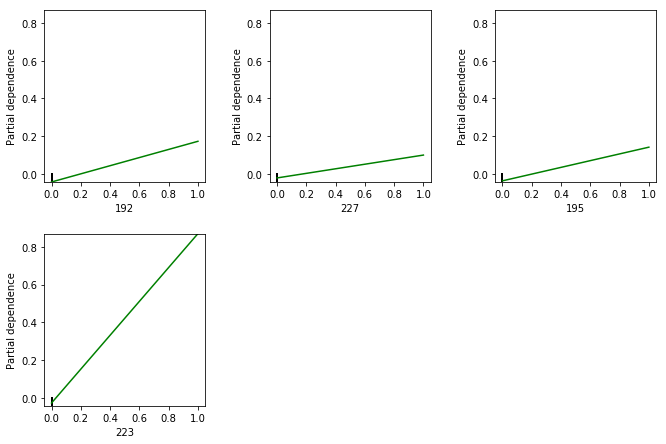

In [58]:
plot_partial_dependence(gbt, X_train, \
                        features = features, label=1)

fig = plt.gcf()
fig.set_size_inches(10,10)

In [62]:
features = []

for col_name in ['AGE', 'BAR_ADMIT_DAYS', 'ARREST_TO_SCREEN', 'CRIMINAL_FLAG']:
    features.append(X_train.columns.get_loc(col_name))

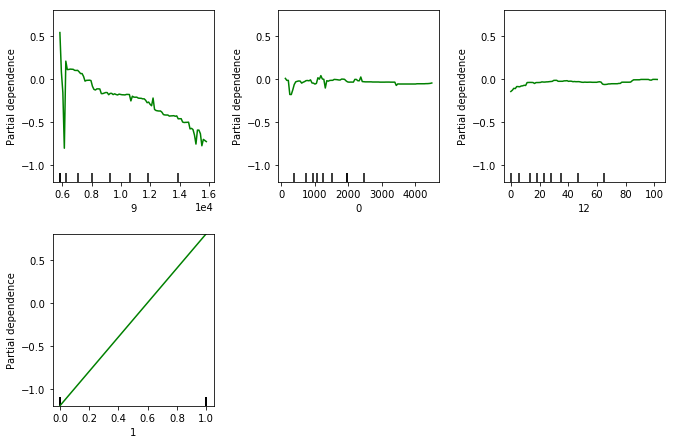

In [63]:
plot_partial_dependence(gbt, X_train, \
                        features = features, label=1)

fig = plt.gcf()
fig.set_size_inches(10,10)

In [60]:
feature_imp.to_csv("Important Features with Charge Desc.csv")